# FCA analysis - preprocessing

In [48]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity =1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures-sn/preprocessing/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.5.3 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


'/home/jovyan/my-conda-envs/SCanalysis/bin/python'

## Import data
Import sample metadata

In [49]:
data_dir = '/nfs/users/nfs_l/lg18/team292/lg18/gonads/data/dual/'
meta = pd.read_csv(data_dir+'/meta.txt',index_col=0, sep='\t')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  4


In [50]:
meta

,donor,Library_ATAC Library_RNA iRods_path
sample,,
HD_F_GON9525419,Hrv15,HD_F_GON9525611 HD_F_GON9525419 ...
HD_F_GON9525420,Hrv15,HD_F_GON9525612 HD_F_GON9525420 ...
HD_F_GON9525421,Hrv39,HD_F_GON9525613 HD_F_GON9525421 ...
HD_F_GON9525422,Hrv39,HD_F_GON9525614 HD_F_GON9525422 ...


## Preprocessing
### Load 10x 

Filter: 1) cells (< 10 genes); 2) genes (< 3 cells) 

Quantify: 1) % mitochondrial genes; 2) total counts


In [51]:
holder = []
for sample in meta.index:
    print(sample)
    # Load 10x data as AnnData
    holder.append(sc.read_10x_mtx(data_dir+'/'+sample+'/filtered_feature_bc_matrix/',cache=True)) 
    # Set names of observation as sample + _ + barcode/probe
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    # Filer cells with less than 10 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=150)
    # add in metadata
    holder[-1].obs['sample'] = sample
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

HD_F_GON9525419


/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Total number of cells: 1412
Total number of genes: 25563
HD_F_GON9525420
Total number of cells: 1455
Total number of genes: 25699
HD_F_GON9525421
Total number of cells: 2036
Total number of genes: 25874
HD_F_GON9525422
Total number of cells: 3556
Total number of genes: 28076


In [52]:
# confirm N samples
print(len(holder))
# merge datasets
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

4


AnnData object with n_obs × n_vars = 8459 × 29398
    obs: 'n_genes', 'sample', 'donor', 'Library_ATAC  Library_RNA      iRods_path', 'percent_mito', 'n_counts', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3'

### QC pplots

Plot distributions of the values n_genes, n_counts and percent_mito

In [53]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf', show=False)

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'donor' as categorical
... storing 'Library_ATAC  Library_RNA      iRods_path' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'gene_ids-2' as categorical
... storing 'feature_types-2' as categorical
... storing 'gene_ids-3' as categorical
... storing 'feature_types-3' as categorical
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/jovyan/my-conda-en

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

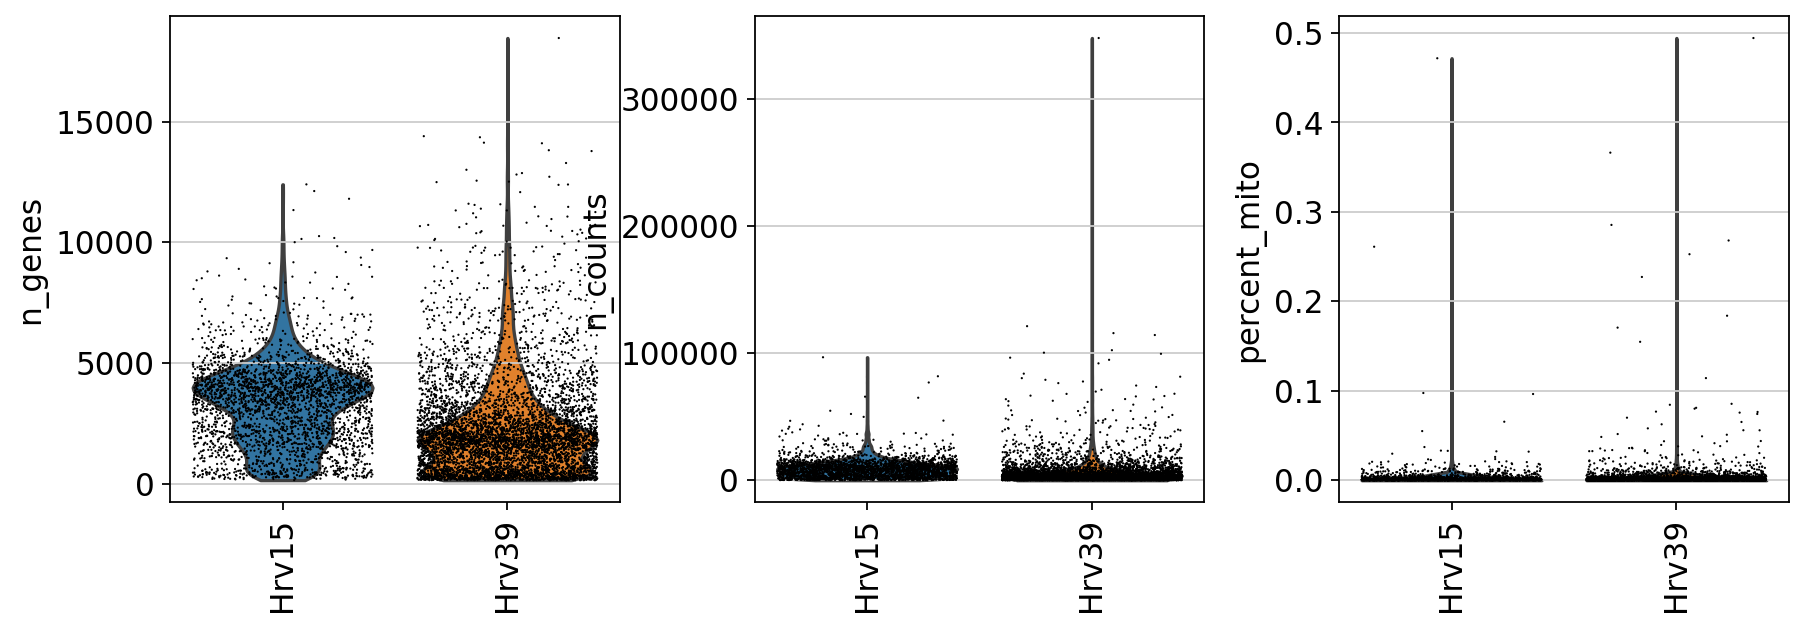

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

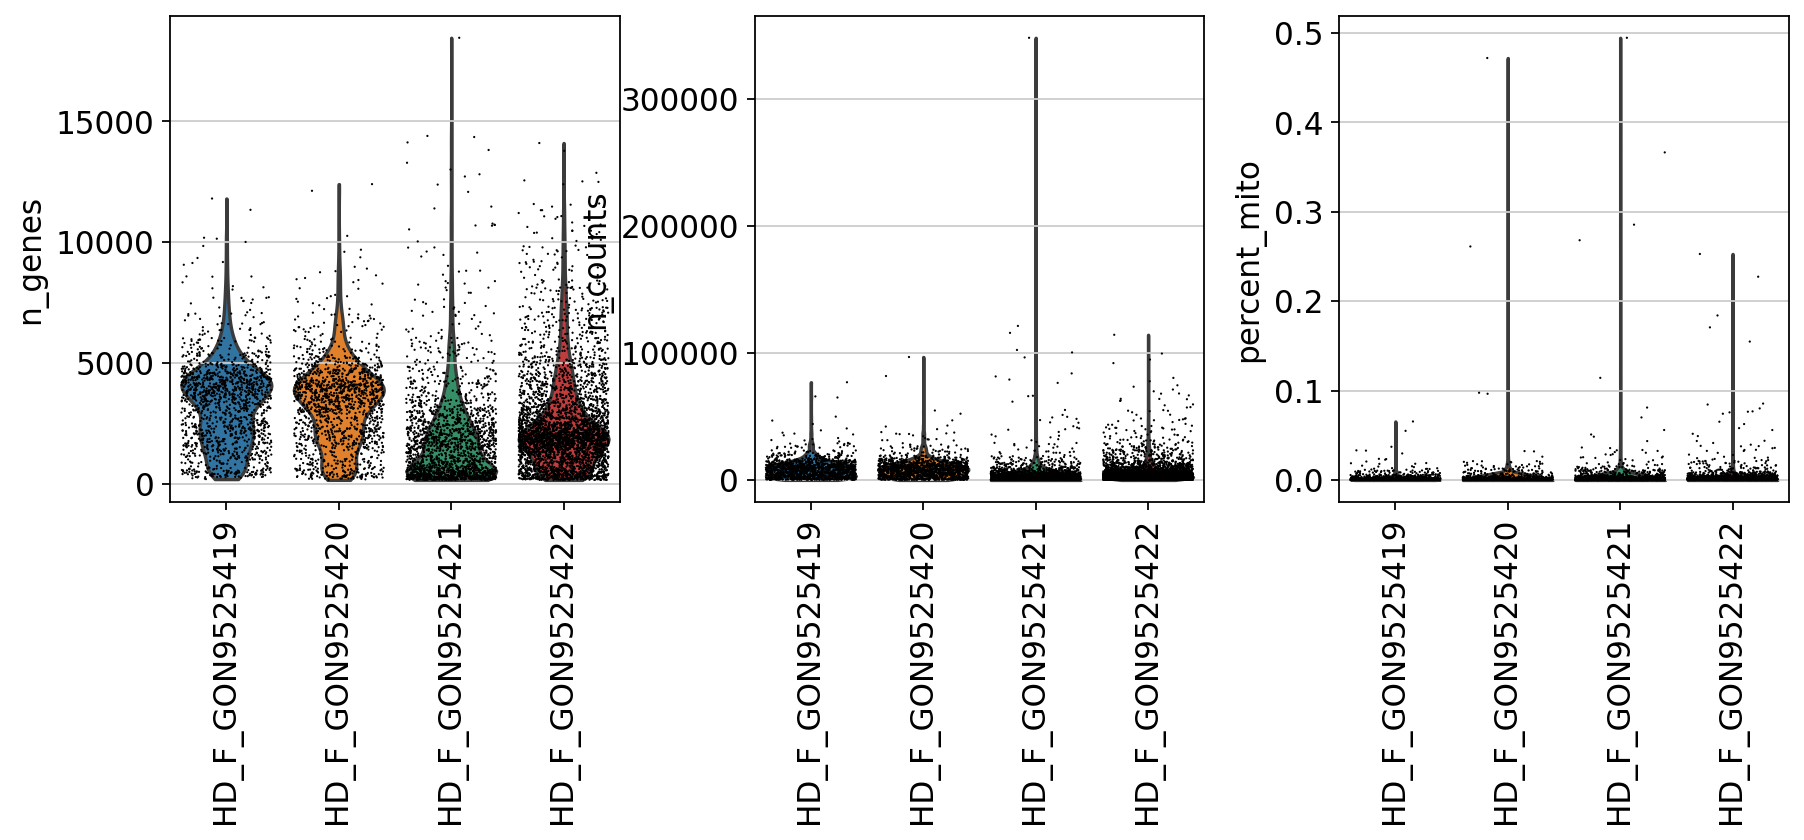

In [54]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='donor', rotation = 90, jitter=0.4, save='_perindividual.pdf', show=True)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='sample', rotation = 90, jitter=0.4, save='_persample.pdf', show=True)

In [55]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_prefilters.csv')

Total number of cells: 8459
Total number of genes: 29398


### Sex specific genes

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

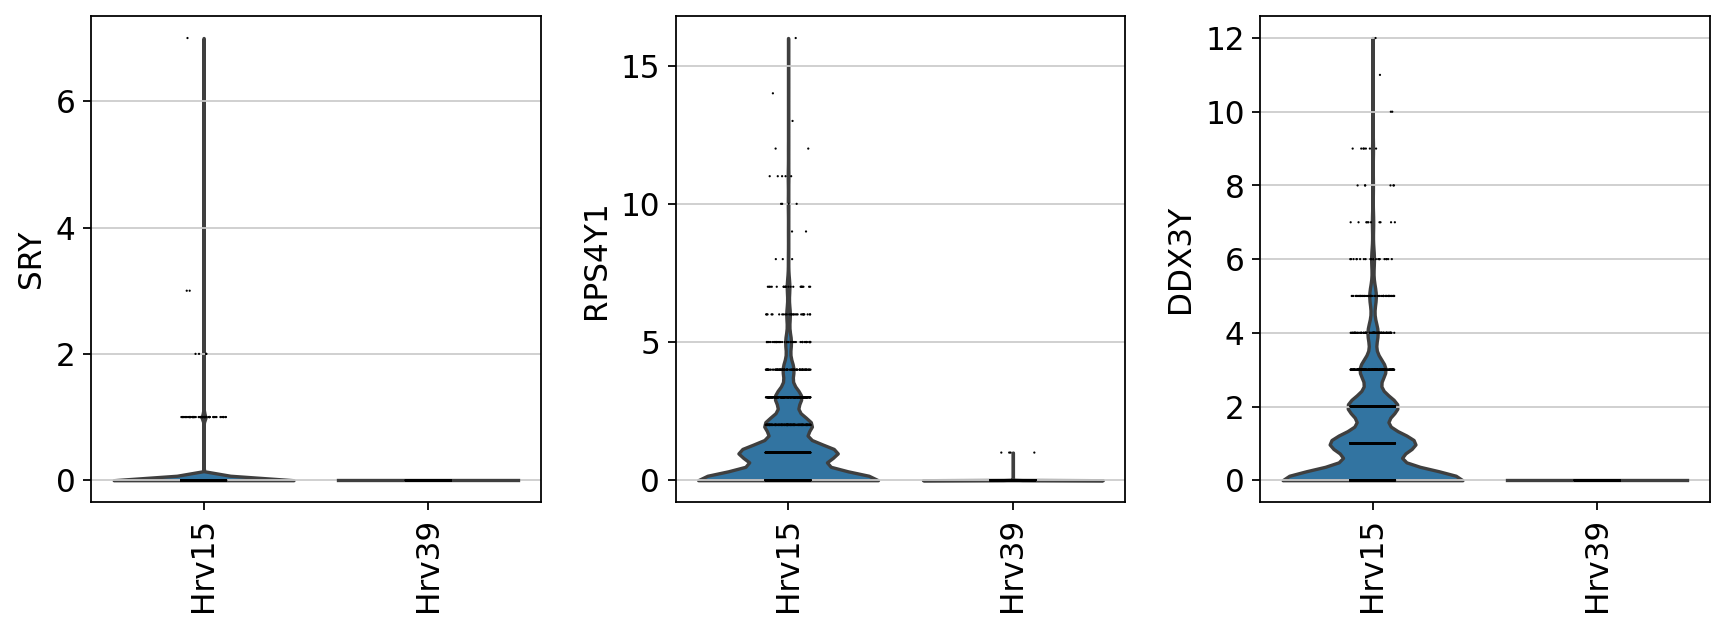

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

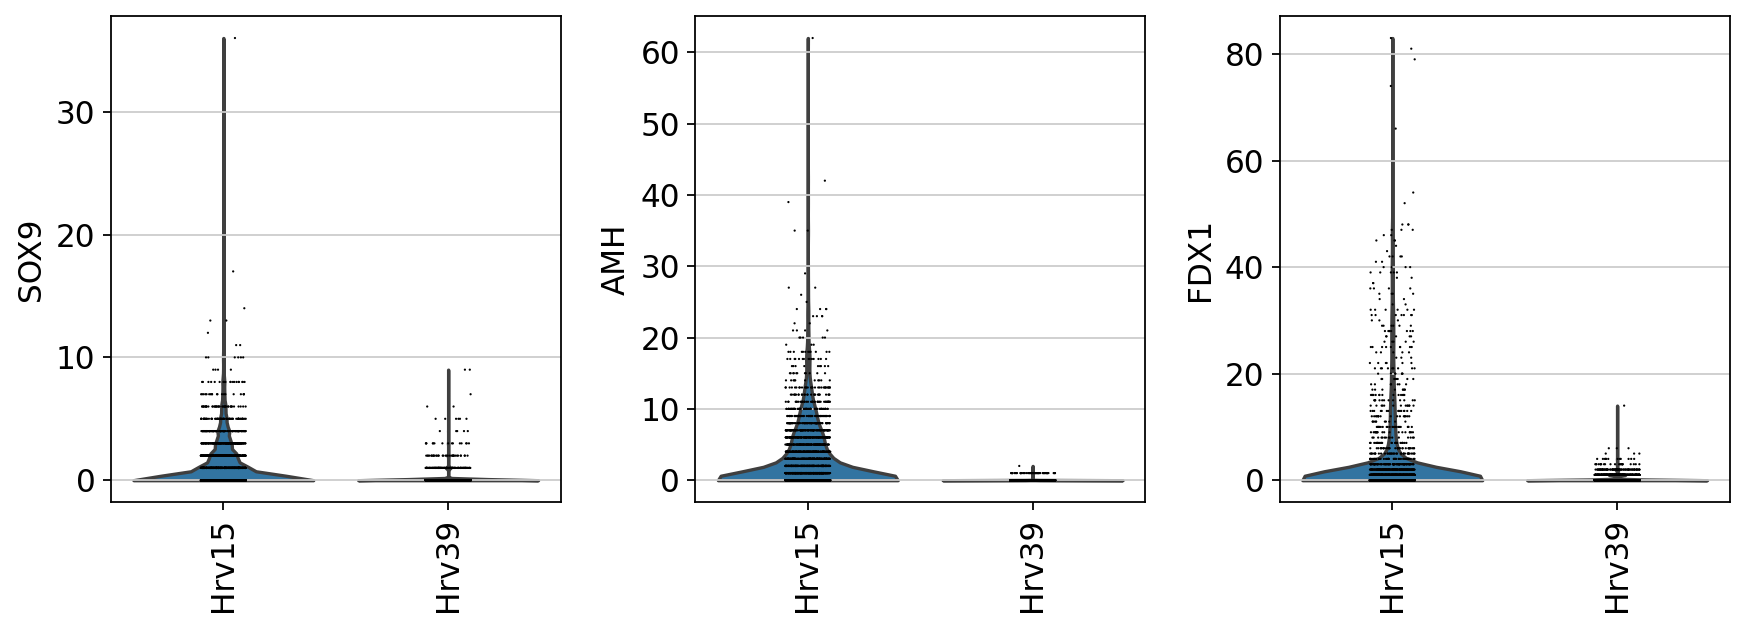

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

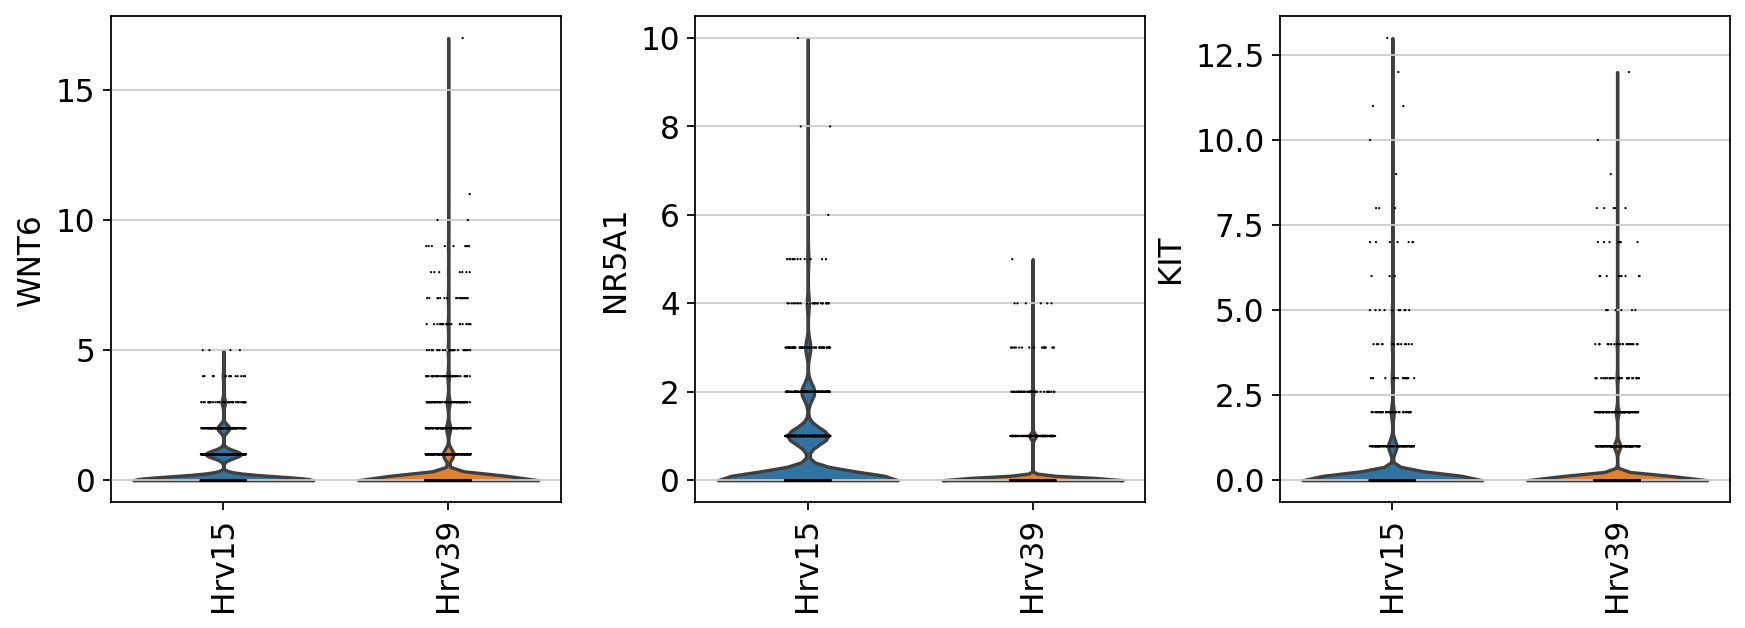

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

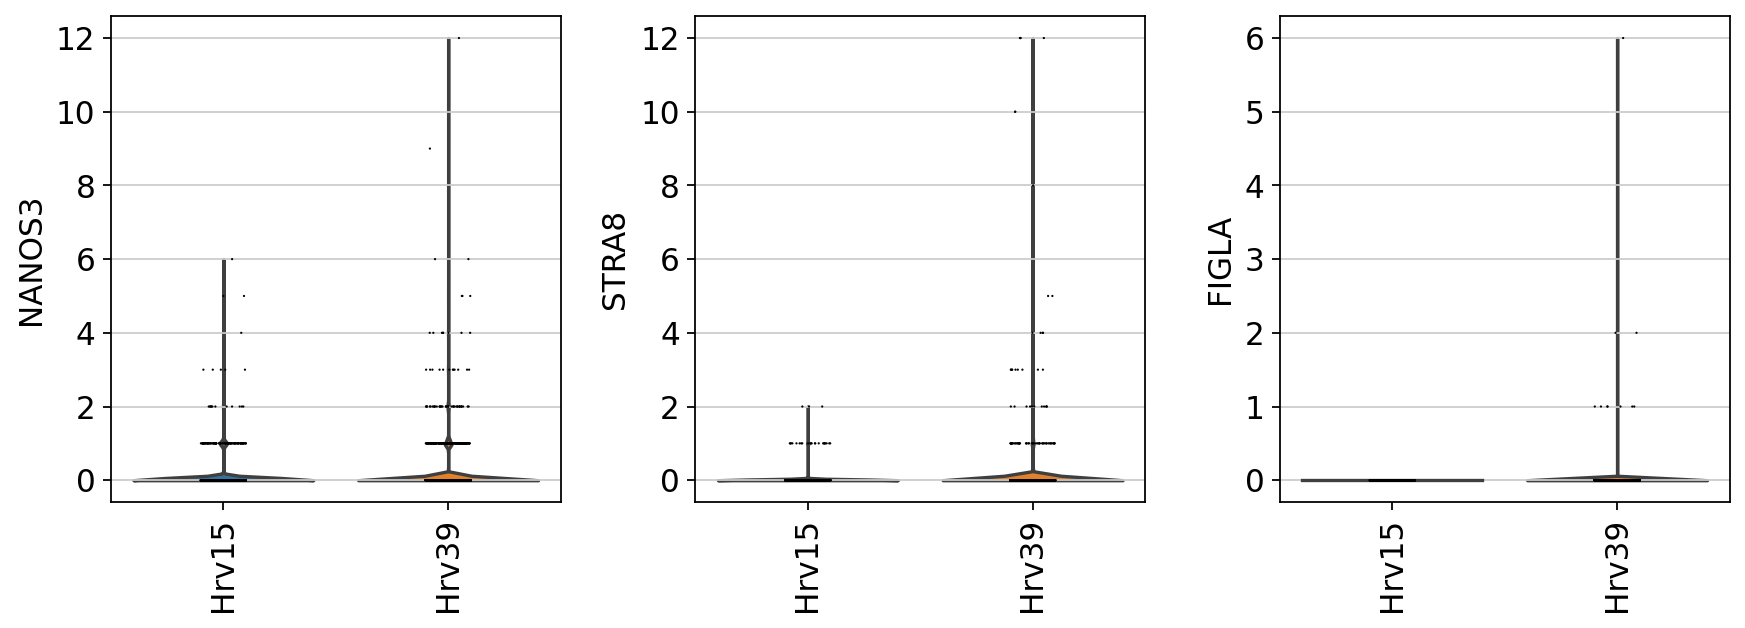

In [56]:
sc.pl.violin(adata, ['SRY', 'RPS4Y1','DDX3Y'], groupby='donor', rotation = 90) # MALE?
sc.pl.violin(adata, ['SOX9', 'AMH', 'FDX1'], groupby='donor', rotation = 90) # GONAD MALE?
sc.pl.violin(adata, ['WNT6', 'NR5A1', 'KIT'], groupby='donor', rotation = 90) # GONAD?
sc.pl.violin(adata, ['NANOS3', 'STRA8', 'FIGLA'], groupby='donor', rotation = 90)# OOCYTES?

### Filter cells with few genes
Check number of genes per cell distribution and filter cells accordingly

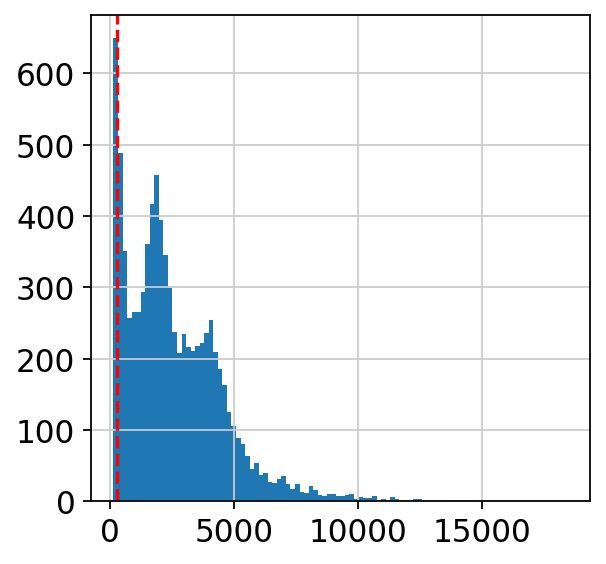

In [57]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(300, linestyle = '--', color = 'red')

In [58]:
sc.pp.filter_cells(adata, min_genes=300)

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [59]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()

Total number of cells: 7933
Total number of genes: 29398


,counts,freqs
categories,,
Hrv15,2822,0.355729
Hrv39,5111,0.644271


### Filter genes expressed in less than 3 cells

In [60]:
sc.pp.filter_genes(adata, min_cells=3)

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [61]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()

Total number of cells: 7933
Total number of genes: 29383


,counts,freqs
categories,,
Hrv15,2822,0.355729
Hrv39,5111,0.644271



### Filter cells with large % mitochondrial genes

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


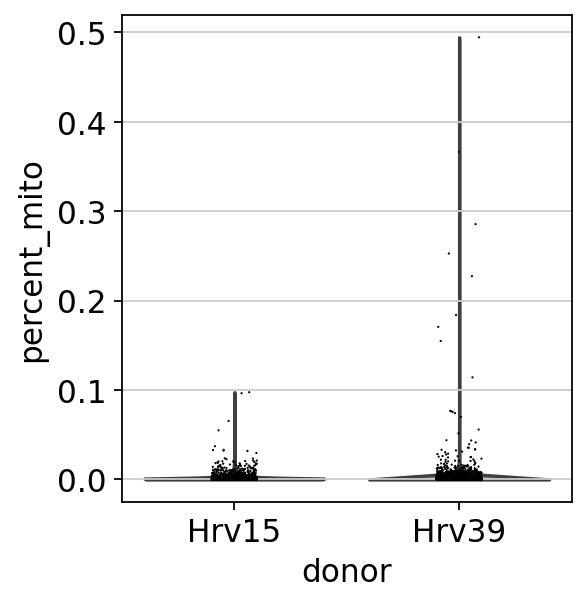

In [62]:
sc.pl.violin(adata, ['percent_mito'], groupby='donor') #hPGCs

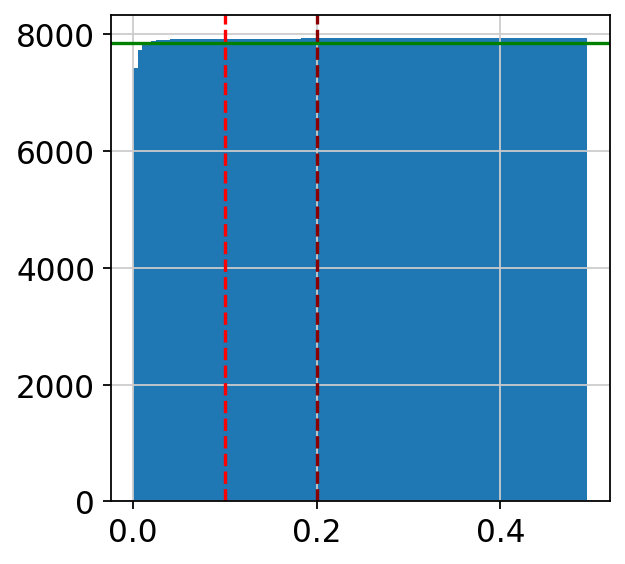

In [63]:
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.1, linestyle = '--', color = 'red')
plt.axvline(0.2, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [64]:
# >10%
adata = adata[adata.obs['percent_mito'] < 0.1, :]

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [65]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_filtered.csv')

Total number of cells: 7924
Total number of genes: 29383


## Save raw counts

In [66]:
adata.raw = adata.copy()

# Save

In [67]:
adata.write('FCAsn-M0counts.h5ad')